# Unsteady Diffusion

#### ZHOU Zixin

In [1]:
import numpy as np
import scipy.sparse as sp
import math
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from scipy.sparse.linalg import eigs

import sys
sys.path.append('src')

from op import *              

## Problem Statement

Consider the following equation:
$$
\dfrac{\partial u}{\partial t} = \nu \dfrac{\partial^2 u}{\partial x^2} \; \; \; 0\le x\le1; \; t \ge 0
$$
with the initial and boundary conditions as:
$$
u(0,t) = u(1,t) = 1 \; \; u(x,0) = \textrm{sin}(\pi x) + 1
$$

## (1) Solve the problem using a collocated mesh and finite difference

### Second order centered scheme 

### (1.a) What is the form of the discrete equation?

In [2]:
# Definition of the grid and BC's
n    = 10
L    = 1.
x    = np.linspace(0, L, num = n+1)[1:-1] 
dxp  = L/n
a    = 1

phi0 = 1.0
phiL = 1.0

print(x)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


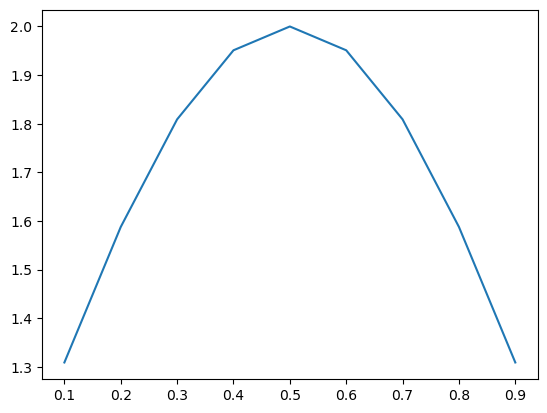

In [3]:
# Definition of the initial condition
u0 = np.sin(np.pi*x)+1

plt.plot(x, u0)
plt.show()

### (1.b) What does the discretisation matrix look like with proper BC's?

In [4]:
# Define matrix B 
B1  = sp.diags([1,-2,1],[-1,0,1],(n-1,n-1)).toarray() 
B1  = (a/dxp**2)*B1

# Define the proper boundary conditions 
SbcW = 0 * x
SbcW [0] = (a/dxp**2) * phi0

SbcE = 0 * x
SbcE [-1] = (a/dxp**2) * phiL


print(B1)

[[-200.  100.    0.    0.    0.    0.    0.    0.    0.]
 [ 100. -200.  100.    0.    0.    0.    0.    0.    0.]
 [   0.  100. -200.  100.    0.    0.    0.    0.    0.]
 [   0.    0.  100. -200.  100.    0.    0.    0.    0.]
 [   0.    0.    0.  100. -200.  100.    0.    0.    0.]
 [   0.    0.    0.    0.  100. -200.  100.    0.    0.]
 [   0.    0.    0.    0.    0.  100. -200.  100.    0.]
 [   0.    0.    0.    0.    0.    0.  100. -200.  100.]
 [   0.    0.    0.    0.    0.    0.    0.  100. -200.]]


### Check the eigenvalues

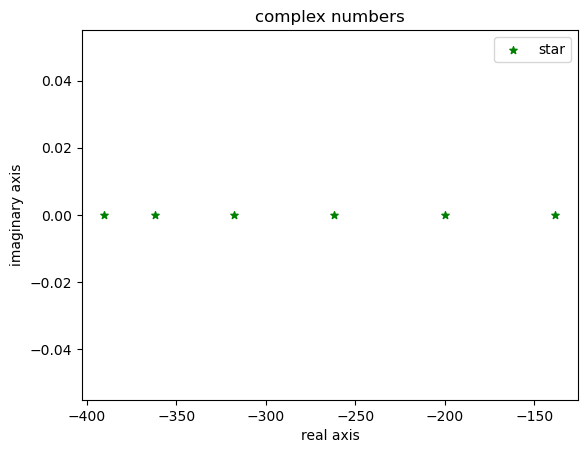

In [5]:
w1, v1 = eigs(B1)
plt.scatter(w1.real, w1.imag, label="star", marker="*", color="green", s=30)
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.title('complex numbers')
plt.legend()
plt.show()

### (1.c) What do the eigenvalues look like? and what can they inform us regarding the time integration scheme?

### (1.d) Use Crank-Nicolson scheme for time integration

In [6]:
from ipywidgets import interact, widgets

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

output_notebook(hide_banner=True)

dt = 0.001
I  = np.identity(n-1)

fig = figure(x_range=(0.0, 1.0), y_range=(1.0, 2.0), width=800, height=400)
plt = fig.line(x, u0,line_width=2)
show(fig, notebook_handle=True)

@interact(Time=widgets.FloatSlider(value=1.0, min=0.01, max=0.2, step=0.005))
def update(Time) :
    nt = int(Time/dt)
    u  = u0 
    for k in range(nt):
        rhs = I.dot(u) + 0.5 * dt * (B1.dot(u)) + dt * (SbcW + SbcE)
        lhs = I - (0.5 * dt * B1)
        u   = np.linalg.solve(lhs,rhs)
    plt.data_source.data = dict(x=x, y=u)
    push_notebook()
 


interactive(children=(FloatSlider(value=0.2, description='Time', max=0.2, min=0.01, step=0.005), Output()), _d…

## (2) Solve the problem using a staggered mesh and finite difference

In [7]:
# Definition of the grid and BC's
n    = 10
L    = 1.
x    = np.linspace(0, L, num = n+1)
xs   = (x[:-1] + x[1:] )/2.0
a    = 1.
dxp  = L/n

phi0 = 1.0
phiL = 1.0


In [8]:
# Initial condition
u0 = np.sin(np.pi*xs)+1


### (2.a) What does the discretisation matrix look like with proper BC's?

In [9]:
# Define matrix B 
A = sp.diags([1,-2,1],[-1,0,1],(n,n)).toarray()

bcW = np.zeros(np.array([1,n]))
bcE = np.zeros(np.array([1,n]))

bcW[0,0] = -4
bcW[0,1] = 4.0/3.0
bcE[0,n-1] = -4.0
bcE[0,n-2] = 4.0/3.0

B2 = np.concatenate((bcW, A[1:-1,:],bcE),axis = 0)
B2 = (a/dxp**2) * B2

# Defining the proper boundary conditions
SbcW = 0 * xs
SbcE = 0 * xs

SbcW[0] = (8./3.) * (a/dxp**2) * phi0
SbcE[-1] = (8./3.) * (a/dxp**2) * phiL


print(B2)

[[-400.          133.33333333    0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ 100.         -200.          100.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.          100.         -200.          100.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.          100.         -200.          100.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.          100.         -200.
   100.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.          100.
  -200.          100.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
   100.         -200.          100.            0.            0.        ]
 [   0.            0.            0.      

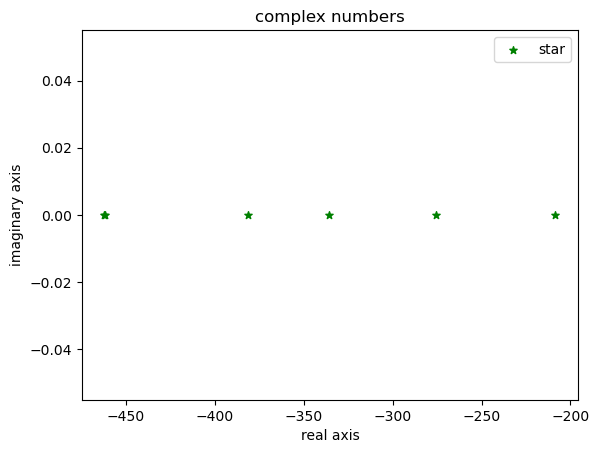

In [10]:
import matplotlib.pylab as plt
w2, v2 = eigs(B2)
plt.scatter(w2.real, w2.imag, label="star", marker="*", color="green", s=30)
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.title('complex numbers')
plt.legend()
plt.show()

### (2.b) Use Crank-Nicolson scheme for time integration

In [11]:
from ipywidgets import interact, widgets

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

output_notebook(hide_banner=True)

dt = 0.001
I  = np.identity(n)

fig = figure(x_range=(0.0, 1.0), y_range=(1.0, 2.0), width=800, height=400)
plt = fig.line(xs, u0,line_width=2)
show(fig, notebook_handle=True)

@interact(Time=widgets.FloatSlider(value=1.0, min=0.01, max=0.2, step=0.005))
def update(Time) :
    nt = int(Time/dt)
    u  = u0 
    for k in range(nt):
        rhs = I.dot(u) + 0.5*(B2.dot(u))*dt + dt *(SbcW + SbcE)
        lhs = I - 0.5*dt*B2
        u   = np.linalg.solve(lhs,rhs)
    plt.data_source.data = dict(x=xs, y=u)
    push_notebook()

interactive(children=(FloatSlider(value=0.2, description='Time', max=0.2, min=0.01, step=0.005), Output()), _d…

## (3) Solve the problem using a staggered mesh and finite volume

### (3.a) What is the form of the discrete equation?

In [12]:
# Definition of the grid and BC's
n    = 10
L    = 1.
x    = np.linspace(0, L, num = n+1)
xs   = (x[:-1] + x[1:] )/2.0
a    = 1
dxp  = L/n

phi0 = 1.0
phiL = 1.0

In [13]:
# Initial condition
u0 = np.sin(np.pi*xs)+1

### (3.b) What does the discretisation matrix look like with proper BC's?

In [14]:
B3    = np.eye(n) 

mass = sp.diags([1./dxp], [0], (n, n)).toarray()

# define the discretisation matrix

Div, Gra = gradient_FV(n,dxp)
B3[1:-1,:] = np.matmul(mass[1:-1,1:-1],np.matmul(Div,Gra))


# Defining the proper boundary conditions
print(B3)

[[   1.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [ 100. -200.  100.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  100. -200.  100.    0.    0.    0.    0.    0.    0.]
 [   0.    0.  100. -200.  100.    0.    0.    0.    0.    0.]
 [   0.    0.    0.  100. -200.  100.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  100. -200.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100. -200.  100.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  100. -200.  100.    0.]
 [   0.    0.    0.    0.    0.    0.    0.  100. -200.  100.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    1.]]


### (3.c) Compare the interior discretisation of the finite difference and finite volume. How do matrices B2 and B3 compare?

### (3.d) Use Crank-Nicolson scheme for time integration

In [15]:
from ipywidgets import interact, widgets

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

output_notebook(hide_banner=True)

dt = 0.001
I  = np.identity(n)

fig = figure(x_range=(0.0, 1.0), y_range=(1.0, 2.0), width=800, height=400)
plt = fig.line(xs, u0,line_width=2)
show(fig, notebook_handle=True)

@interact(Time=widgets.FloatSlider(value=1.0, min=0.01, max=0.2, step=0.005))
def update(Time) :
    nt = int(Time/dt)
    u  = u0 
    for k in range(nt):
        rhs = rhs = I.dot(u) + 0.5*(B3.dot(u))*dt + dt *(SbcW + SbcE)
        lhs = I - 0.5*dt*B3
        u   = np.linalg.solve(lhs,rhs)
    plt.data_source.data = dict(x=xs, y=u)
    push_notebook()

interactive(children=(FloatSlider(value=0.2, description='Time', max=0.2, min=0.01, step=0.005), Output()), _d…